In [1]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

(-1, 1)

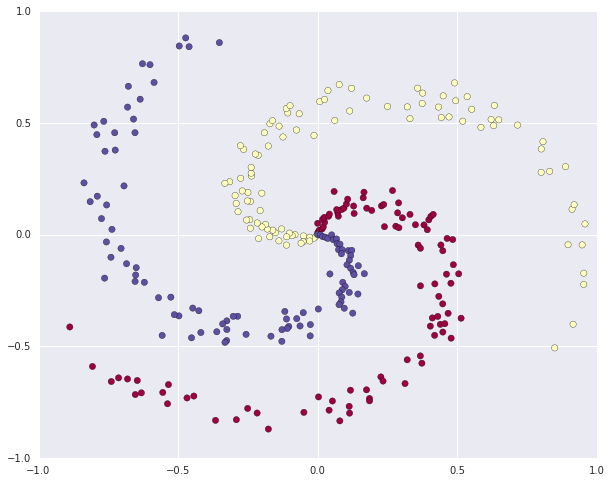

In [2]:
np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)).astype(np.float32)
y = np.zeros(N*K, dtype='uint8')
for j in xrange(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
    fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])

In [3]:
print(X.shape)
print(y.shape)
Y = (np.arange(K) == y[:,None]).astype(np.float32)
print(Y.shape)

(300, 2)
(300,)
(300, 3)


Loss at step 0: 1.303453
Training accuracy: 26.7%
Loss at step 100: 0.796484
Training accuracy: 49.0%
Loss at step 200: 0.778623
Training accuracy: 49.0%
Loss at step 300: 0.776022
Training accuracy: 49.0%
Loss at step 400: 0.775495
Training accuracy: 49.3%
Loss at step 500: 0.775373
Training accuracy: 49.3%
Loss at step 600: 0.775343
Training accuracy: 49.3%
Loss at step 700: 0.775336
Training accuracy: 49.3%
Loss at step 800: 0.775334
Training accuracy: 49.3%


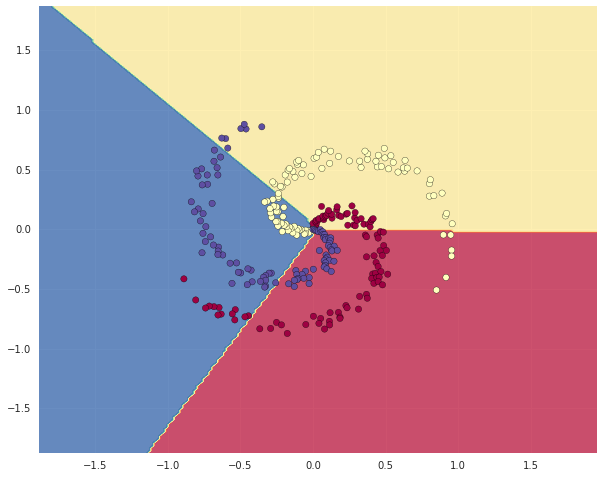

In [4]:
# ************************************************************************************
# ************************* Version simple linear classifier *************************
# ************************************************************************************

import tensorflow as tf
graph = tf.Graph()
with graph.as_default():

    # Input data, load the training data into constants that are attached to the graph.
    tf_train_dataset = tf.constant(X)
    tf_train_labels = tf.constant(Y)

    # These are the parameters that we are going to be training. The weight matrix will be initialized using random valued following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable( tf.truncated_normal([D, K]) )
    biases = tf.Variable(tf.zeros([K]))

    # We multiply the inputs with the weight matrix, and add biases. We compute the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) )

    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training. These are not part of training, but merely here so that we can report accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)


def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

num_steps = 801
with tf.Session(graph=graph) as session:
# This is a one-time operation which ensures the parameters get initialized as we described in the graph: random weights for the matrix, zeros for the biases.
    tf.initialize_all_variables().run()
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer and get the loss value and the training predictions returned as numpy arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 100 == 0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(predictions, Y))
            # Calling .eval() on valid_prediction is basically like calling run(), but just to get that one numpy array. Note that it recomputes all its graph dependencies.

    # plot the resulting classifier
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = np.dot(np.c_[xx.ravel(), yy.ravel()], weights.eval()) + biases.eval()
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    #fig.savefig('spiral_linear.png')

Training accuracy: 89.3%


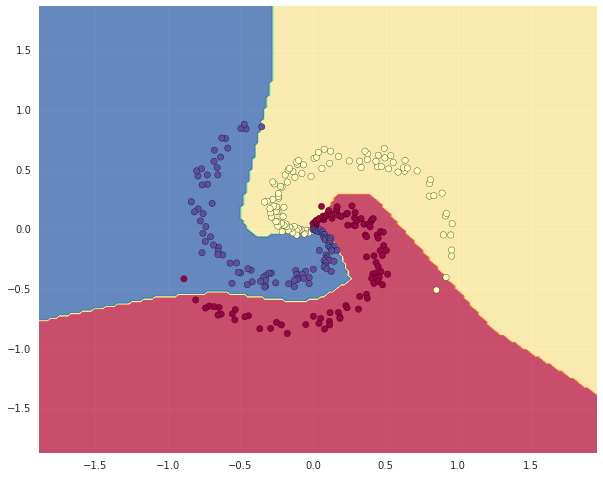

In [6]:
# ************************************************************************************
# ********************* Version with 1 hidden layer with ReLU > softmax **************
# ************************************************************************************

hidden_nodes = 10

graph = tf.Graph()
with graph.as_default():

    # Input data, load the training data into constants that are attached to the graph.
    tf_train_dataset = tf.constant(X)
    tf_train_labels = tf.constant(Y)

    # These are the parameters that we are going to be training. The weight matrix will be initialized using random valued following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights_1 = tf.Variable(tf.truncated_normal([D, hidden_nodes]))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes, K]))
    biases_2 = tf.Variable(tf.zeros([K]))

    # We multiply the inputs with the weight matrix, and add biases. We compute the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this cross-entropy across all training examples: that's our loss.
    def fwd_prop(inp):
        hidden_1 = tf.nn.relu(tf.matmul(inp, weights_1) + biases_1)
        logits = tf.matmul(hidden_1,weights_2) + biases_2
        softmax = tf.nn.softmax(logits)
        return logits, softmax

    #loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) )
    logits, _ = fwd_prop(tf_train_dataset)
    L2 = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2)
    loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + 0.005*L2 ) 

    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training. These are not part of training, but merely here so that we can report accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)


num_steps = 1001
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 100 == 0):
            a=0
            #print('Loss at step %d: %f' % (step, l))
            #print('Training accuracy: %.1f%%' % accuracy(predictions, Y))
    print('Training accuracy: %.1f%%' % accuracy(predictions, Y))

    # plot the resulting classifier
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    xx = xx.astype(np.float32)
    yy = yy.astype(np.float32)

    xx1 = np.reshape(xx,[xx.size,1])
    yy1 = np.reshape(yy,[yy.size,1])
    Z1 = np.hstack((xx1,yy1))
    _, Z = fwd_prop(Z1)
    Z2 = np.argmax(Z.eval(), axis=1)
    Z3 = Z2.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z3, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    #fig.savefig('spiral_linear.png')